In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np

In [2]:
from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_leaky_relu = 0.01

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, batch_size="pog", channels=256, alpha=0.01):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        
        self.bnorm1 = nn.BatchNorm2d(channels)
        self.bnorm2 = nn.BatchNorm2d(channels)
        
        self.lrelu1 = nn.LeakyReLU(alpha)
        
    def forward(self, _input):
        x = self.conv1(_input)
        # todo: try relu before batch norm
        x = self.bnorm1(x)
        x = self.lrelu1(x)
        x = self.conv2(x)
        x = self.bnorm2(x)
        
        res = x + _input
        return res

In [5]:
class Generator(nn.Module):
    def __init__(self, batch_size="pog", channels=3, img_height=256, img_width=256):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        
        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        
        self.rblock1 = ResNetBlock(batch_size, 256)
        self.rblock2 = ResNetBlock(batch_size, 256)
        self.rblock3 = ResNetBlock(batch_size, 256)
        self.rblock4 = ResNetBlock(batch_size, 256)
        self.rblock5 = ResNetBlock(batch_size, 256)
        self.rblock6 = ResNetBlock(batch_size, 256)
        self.rblock7 = ResNetBlock(batch_size, 256)
        self.rblock8 = ResNetBlock(batch_size, 256)
        self.rblock9 = ResNetBlock(batch_size, 256)
        
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)
        
        self.bnorm4 = nn.BatchNorm2d(128)
        self.bnorm5 = nn.BatchNorm2d(64)
        
    def forward(self, _input):
        x = self.conv1(_input)
        x = F.leaky_relu(self.bnorm1(x), negative_slope=0.01)
        
        x = self.conv2(x)
        x = F.leaky_relu(self.bnorm2(x), negative_slope=0.01)
        
        x = self.conv3(x)
        x = F.leaky_relu(self.bnorm3(x), negative_slope=0.01)
        
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        x = self.rblock4(x)
        x = self.rblock5(x)
        x = self.rblock6(x)
        x = self.rblock7(x)
        x = self.rblock8(x)
        x = self.rblock9(x)
        
        x = self.conv_trans1(x)
        x = F.leaky_relu(self.bnorm4(x), negative_slope=0.01)
        
        x = self.conv_trans2(x)
        x = F.leaky_relu(self.bnorm5(x), negative_slope=0.01)
        
        x = self.final_conv(x)
        
        res = torch.tanh(x)
        
        return res


In [6]:
sanity_check_generator_model = Generator().to(device)
summary(sanity_check_generator_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3        [-1, 128, 128, 128]          73,856
       BatchNorm2d-4        [-1, 128, 128, 128]             256
            Conv2d-5          [-1, 256, 64, 64]         295,168
       BatchNorm2d-6          [-1, 256, 64, 64]             512
            Conv2d-7          [-1, 256, 64, 64]         590,080
       BatchNorm2d-8          [-1, 256, 64, 64]             512
         LeakyReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
      BatchNorm2d-11          [-1, 256, 64, 64]             512
      ResNetBlock-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
      BatchNorm2d-14          [-1, 256,

In [7]:
class Discriminator(nn.Module):
    """
    pix2pix discriminator
    """
    def __init__(self, batch_size="pog", channels=3, img_height=256, img_width=256):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
        
        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.bnorm4 = nn.BatchNorm2d(512)
        
    def forward(self, _input):
        x = self.conv1(_input)
        x = F.leaky_relu(self.bnorm1(x), negative_slope=0.01)
        
        x = self.conv2(x)
        x = F.leaky_relu(self.bnorm2(x), negative_slope=0.01)
        
        x = self.conv3(x)
        x = F.leaky_relu(self.bnorm3(x), negative_slope=0.01)
        
        x = self.conv4(x)
        x = F.leaky_relu(self.bnorm4(x), negative_slope=0.01)
        
        res = self.conv5(x)
        return res

In [8]:
sanity_check_discriminator_model = Discriminator().to(device)
summary(sanity_check_discriminator_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
            Conv2d-5          [-1, 256, 32, 32]         524,544
       BatchNorm2d-6          [-1, 256, 32, 32]             512
            Conv2d-7          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-8          [-1, 512, 31, 31]           1,024
            Conv2d-9            [-1, 1, 30, 30]           8,193
Total params: 2,766,657
Trainable params: 2,766,657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 35.51
Params size (MB): 10.55
Estimated Total Size (MB): 46.82
------------------------------------

## Start by making a regular training loop, and then turn it into a class

In [9]:
# Improvements: Explore using detach to make it possible to just do all the grad steps with one single cycle

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: send to device. after debugging loop
g_az = Generator()
g_za = Generator()

d_a = Discriminator()
d_z = Discriminator()

loss_gan = nn.MSELoss()
loss_discrim = nn.L1Loss()
loss_cycle = nn.L1Loss()
loss_identity_mult = nn.L1Loss()

g_params = list(g_az.parameters()) + list(g_za.parameters())
d_params = list(d_a.parameters()) + list(d_z.parameters())

g_opt = Adam(g_params, lr=0.001)
d_opt = Adam(d_params, lr=0.001)

loss_gan_mult = 5
loss_cycle_mult = 10
loss_identity_mult = 1


def train(batch):
    """
    single step training
    """
    a_imgs_real = batch['a']
    z_imgs_real = batch['z']


    # Discriminator Training
    # note: can you run detach on generator outputs here?
    
    d_opt.zero_grad()
    # real images
    guess_d_a = d_a(a_imgs_real)
    d_a_same_loss = torch.mean((1 - guess_d_a)**2)
    
    guess_d_z = d_z(z_imgs_real)
    d_z_same_loss = torch.mean((1 - guess_d_z)**2)
    
    total_d_real_loss = d_a_same_loss + d_z_same_loss  # TODO: MULTIPLY HERE
    
    total_d_real_loss.backward()
    d_opt.step()
    
    d_opt.zero_grad()
    
    # generated fake images
    generated_img_a = g_za(z_imgs_real)
    guess_d_a = d_a(generated_img_a)  # for the resultant of a to z
    d_a_fake_loss = torch.mean((guess_d_a)**2)  # same as (0 - generated_img_a)**2
    
    generated_img_z = g_az(a_imgs_real)
    guess_d_z = d_z(generated_img_z)
    d_z_fake_loss = torch.mean((guess_d_z)**2)
    
    total_d_fake_loss = d_a_fake_loss + d_z_fake_loss  # TODO: MULTIPLY HERE
    
    total_d_fake_loss.backward()
    d_opt.step()
    
    
    # Generator Training
    
    g_opt.zero_grad()
    # a - z - a cycle loss (and also generator loss)
    generated_img_z = g_az(a_imgs_real)
    guess_d_z = d_z(generated_img_z)
    
    g_az_loss = torch.mean((1 - guess_d_z)**2)  # TODO: MULTIPLY HERE
    # continue the cycle
    generated_cycled_img_a = g_za(generated_img_z)
    
    aza_cycle_loss = torch.mean((a_imgs_real - generated_cycled_img_a)**2)
    
    total_aza_loss = g_az_loss + aza_cycle_loss
    total_aza_loss.backward()
    g_opt.step()
    
    g_opt.zero_grad()
    # z - a - z cycle loss (and also generator loss)
    generated_img_a = g_za(z_imgs_real)
    guess_d_a = d_a(generated_img_a)
    
    g_za_loss = torch.mean((1 - guess_d_a)**2)  # TODO: MULTIPLY HERE
    # continue the cycle
    generated_cycled_img_z = g_az(generated_img_a)
    
    zaz_cycle_loss = torch.mean((z_imgs_real - generated_cycled_img_z)**2)
    
    total_zaz_loss = g_za_loss + zaz_cycle_loss  # TODO: MULTIPLY HERE
    total_zaz_loss.backward()
    g_opt.step()
    
    
    # Identity Loss
    g_opt.zero_grad()
    
    generated_identity_img_z = g_az(z_imgs_real)
    identity_loss_az = torch.mean(torch.abs(z_imgs_real - generated_identity_img_z))
    
    generated_identity_img_a = g_za(a_imgs_real)
    identity_loss_za = torch.mean(torch.abs(a_imgs_real - generated_identity_img_a))
    
    total_identity_loss = identity_loss_az + identity_loss_za  # TODO: MULTIPLY HERE (by 1 lol)
    
    total_identity_loss.backward()
    g_opt.step()


## TODO:

- Add multiplication factors to losses
- Add dataloader + generator
- Add image buffer (once main loop works)

data directory structure (from root)

```
--> data
 |
 ---> a_dir
 |
 ---> z_dir
 
```

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import glob
import os
import random

class CycleGANDataset(Dataset):
    def __init__(self, a_dir, z_dir, file_extension='*.jpg', transform=None, aligned=False):
        super(CycleGANDataset, self).__init__()
        self.a_arr = glob.glob(os.path.join(a_dir, file_extension))
        self.z_arr = glob.glob(os.path.join(z_dir, file_extension))
        self.a_dir = a_dir
        self.z_dir = z_dir
        self.transform = transform
        self.aligned = aligned
    
    def __len__(self):
        # could be a arr or z arr, shouldn't matter
        return max(len(self.a_arr), len(self.z_arr))
    
    def __getitem__(self, index):
        """Generate one sample of data, based on dirty data"""
        
        # grab a random index for each. the modulus allows overflow, and makes it unaligned if overflow
        idx_a = index % len(self.a_arr)
        if self.aligned:
            idx_z = index % len(self.z_arr)
        else:
            idx_z = random.randint(0, len(self.z_arr) - 1)
        
        a_img_name = os.path.basename(self.a_arr[idx_a])
        z_img_name = os.path.basename(self.z_arr[idx_z])
        a_path = os.path.join(self.a_dir, a_img_name)
        z_path = os.path.join(self.z_dir, z_img_name)
        transformed_a = Image.open(a_path)
        transformed_z = Image.open(z_path)
        
        if self.transform:
            # notice how with each transform, they are each independent.
            # this allows the random crop and flips to be different with each img
            # because cyclegan is meant for unpaired it won't matter
            transformed_a = self.transform(transformed_a)
            transformed_z = self.transform(transformed_z)
        
        return {'a': transformed_a, 'z': transformed_z}

In [24]:
from torchvision import transforms

img_h = 256
img_w = 256

trans = transforms.Compose([
    transforms.Resize((int(img_h*1.12),int(img_w*1.12)), Image.BICUBIC), # make it bigger so random crop is more random
    transforms.RandomCrop((img_h, img_w)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5)) # mean, std of each channel. can provice a tuple for 3 dim images
])
training_set = CycleGANDataset(a_dir='./data/a_dir', z_dir='./data/z_dir', transform=trans)

In [25]:
from torch.utils.data import DataLoader

params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 1}

training_generator = DataLoader(training_set, **params)

In [26]:
glob.glob(os.path.join('./data/a_dir', '*.jpg'))

['./data/a_dir/IMG_5267.jpg',
 './data/a_dir/IMG_5268.jpg',
 './data/a_dir/IMG_5269.jpg',
 './data/a_dir/koalastare.jpg',
 './data/a_dir/nautilus.jpg',
 './data/a_dir/drone.jpg']

In [15]:
n_epochs = 2
for epoch in range(0, n_epochs):
    print("hi")
    for i, batch in enumerate(training_generator):
        train(batch)

hi
hi


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: send to device. after debugging loop
g_az = Generator().to(device)
g_za = Generator().to(device)

d_a = Discriminator().to(device)
d_z = Discriminator().to(device)

g_params = list(g_az.parameters()) + list(g_za.parameters())
d_params = list(d_a.parameters()) + list(d_z.parameters())

g_opt = Adam(g_params, lr=0.001)
d_opt = Adam(d_params, lr=0.001)

loss_gan_mult = 5
loss_cycle_mult = 10
loss_identity_mult = 1


def train_gpu(batch):
    """
    single step training
    """
    a_imgs_real = batch['a'].to(device)
    z_imgs_real = batch['z'].to(device)


    # Discriminator Training
    # note: can you run detach on generator outputs here?
    
    d_opt.zero_grad()
    # real images
    guess_d_a = d_a(a_imgs_real)
    d_a_same_loss = torch.mean((1 - guess_d_a)**2)
    
    guess_d_z = d_z(z_imgs_real)
    d_z_same_loss = torch.mean((1 - guess_d_z)**2)
    
    total_d_real_loss = d_a_same_loss + d_z_same_loss  # TODO: MULTIPLY HERE
    
    total_d_real_loss.backward()
    d_opt.step()
    
    d_opt.zero_grad()
    
    # generated fake images
    generated_img_a = g_za(z_imgs_real)
    guess_d_a = d_a(generated_img_a)  # for the resultant of a to z
    d_a_fake_loss = torch.mean((guess_d_a)**2)  # same as (0 - generated_img_a)**2
    
    generated_img_z = g_az(a_imgs_real)
    guess_d_z = d_z(generated_img_z)
    d_z_fake_loss = torch.mean((guess_d_z)**2)
    
    total_d_fake_loss = d_a_fake_loss + d_z_fake_loss  # TODO: MULTIPLY HERE
    
    total_d_fake_loss.backward()
    d_opt.step()
    
    
    # Generator Training
    
    g_opt.zero_grad()
    # a - z - a cycle loss (and also generator loss)
    generated_img_z = g_az(a_imgs_real)
    guess_d_z = d_z(generated_img_z)
    
    g_az_loss = torch.mean((1 - guess_d_z)**2)  # TODO: MULTIPLY HERE
    # continue the cycle
    generated_cycled_img_a = g_za(generated_img_z)
    
    aza_cycle_loss = torch.mean((a_imgs_real - generated_cycled_img_a)**2)
    
    total_aza_loss = g_az_loss + aza_cycle_loss * loss_cycle_mult
#     print("total_aza_loss shape:")
#     print(total_aza_loss.shape)
    total_aza_loss.backward()
    g_opt.step()
    
    g_opt.zero_grad()
    # z - a - z cycle loss (and also generator loss)
    generated_img_a = g_za(z_imgs_real)
    guess_d_a = d_a(generated_img_a)
    
    g_za_loss = torch.mean((1 - guess_d_a)**2)  # TODO: MULTIPLY HERE
    # continue the cycle
    generated_cycled_img_z = g_az(generated_img_a)
#     print('gen cycle img z')
#     print(((1 - guess_d_a)**2).shape)
    
    zaz_cycle_loss = torch.mean((z_imgs_real - generated_cycled_img_z)**2)
#     print(((z_imgs_real - generated_cycled_img_z)**2).shape)
    
    total_zaz_loss = g_za_loss + zaz_cycle_loss * loss_cycle_mult # TODO: MULTIPLY HERE
    total_zaz_loss.backward()
    g_opt.step()
    
    
    # Identity Loss
    g_opt.zero_grad()
    
    generated_identity_img_z = g_az(z_imgs_real)
    identity_loss_az = torch.mean(torch.abs(z_imgs_real - generated_identity_img_z))
    
    generated_identity_img_a = g_za(a_imgs_real)
    identity_loss_za = torch.mean(torch.abs(a_imgs_real - generated_identity_img_a))
    
    total_identity_loss = identity_loss_az + identity_loss_za  # TODO: MULTIPLY HERE (by 1 lol)
    
    total_identity_loss.backward()
    g_opt.step()


In [27]:
n_epochs = 2
for epoch in range(0, n_epochs):
    print("hi")
    for i, batch in enumerate(training_generator):
        train_gpu(batch)

hi
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])
hi
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])
total_aza_loss shape:
torch.Size([])
gen cycle img z
torch.Size([2, 1, 30, 30])
torch.Size([2, 3, 256, 256])


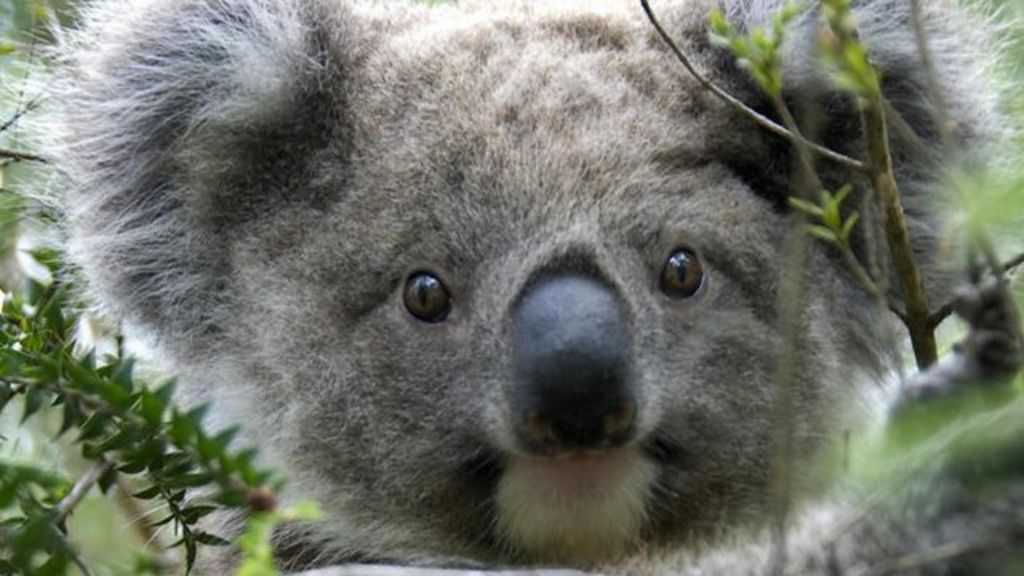

In [23]:
# to generate an image
img = glob.glob(os.path.join('./data/a_dir', '*.jpg'))[3]
img = Image.open(img)
img

In [54]:
predict_transform = transforms.Compose([
    transforms.Resize((int(img_h),int(img_w)), Image.BICUBIC),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # mean, std of each channel. can provice a tuple for 3 dim images
])


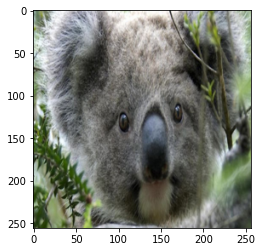

In [55]:
import matplotlib.pyplot as plt
new_img = predict_transform(img)
plt.imshow(new_img.permute(1, 2, 0))  # (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


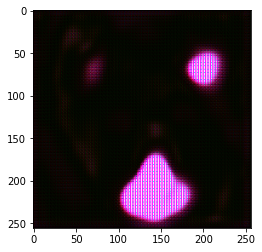

In [57]:
plt.imshow(g_az(new_img.unsqueeze(0).to(device)).cpu().detach().squeeze().permute(1, 2, 0))